In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

# import needed packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LSTM, TimeDistributed
from keras.optimizers import RMSprop, Adam, SGD
from keras.regularizers import l2, l1, L1L2
from keras.initializers import Constant, RandomNormal, RandomUniform, TruncatedNormal
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.losses import mean_squared_error
from keras import backend as K

Using TensorFlow backend.


In [2]:
loader = np.load("homework_09_data.npz")

train_data = loader['train_data']
train_labels = loader['train_labels']

val_data = loader['val_data']
val_labels = loader['val_labels']

learn_data = np.concatenate((train_data, val_data), axis=0)
learn_labels = np.concatenate((train_labels, val_labels), axis=0)

test_data = loader['test_data']

In [3]:
scaler = StandardScaler()

train_data = scaler.fit_transform(train_data)
val_data = scaler.fit_transform(val_data)
learn_data = scaler.fit_transform(learn_data)
test_data = scaler.fit_transform(test_data)

/home/julius/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/julius/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/julius/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/julius/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/julius/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarnin

In [4]:
# catch annoying sklearn warnings
def warn(*args, **kwargs):
    pass

warnings.warn = warn

In [28]:
# define hyperparameters

USE_DROPOUT = False
USE_BATCH_NORM = True
CLIP_GRADIENTS = False

clip_value = 0.05
lr = 0.01
dropout_rate = 0.1
loss_func = 'categorical_crossentropy'
epochs = 250
weight_initializer =TruncatedNormal(mean=0.0, stddev=0.05)
bias_initializer = Constant(0.1)

if CLIP_GRADIENTS:
    optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, clipvalue=clip_value)
else:
    optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None)
    
input_dim = np.shape(train_data[0])[0]
weight_decay =  l2(0.)
metrics = ['accuracy']
hidden_activation = 'relu'
output_activation = 'softmax'
batch_size = 128
hidden_layer_size = 64
num_classes = np.shape(train_labels[0])[0]

In [29]:
# build feedforward net
model = Sequential()

# input layer
model.add(Dense(512,
                activation=hidden_activation,
                kernel_initializer=weight_initializer,
                kernel_regularizer=weight_decay,
                bias_initializer=bias_initializer,
                input_dim=input_dim))

# dropout layer
if USE_DROPOUT:
    model.add(Dropout(dropout_rate))

# batch norm layer
if USE_BATCH_NORM:
    model.add(BatchNormalization())

# hidden layer 1
model.add(Dense(256,
                activation=hidden_activation,
                kernel_initializer=weight_initializer,
                kernel_regularizer=weight_decay,
                bias_initializer=bias_initializer,
                input_dim=input_dim))

# dropout layer
if USE_DROPOUT:
    model.add(Dropout(dropout_rate))

# batch norm layer
if USE_BATCH_NORM:
    model.add(BatchNormalization())

# hidden layer 2
model.add(Dense(256,
                activation=hidden_activation,
                kernel_initializer=weight_initializer,
                kernel_regularizer=weight_decay,
                bias_initializer=bias_initializer,
                input_dim=input_dim))

# dropout layer
if USE_DROPOUT:
    model.add(Dropout(dropout_rate))

# batch norm layer
if USE_BATCH_NORM:
    model.add(BatchNormalization())

# hidden layer 2
model.add(Dense(128,
                activation=hidden_activation,
                kernel_initializer=weight_initializer,
                kernel_regularizer=weight_decay,
                bias_initializer=bias_initializer,
                input_dim=input_dim))

# dropout layer
if USE_DROPOUT:
    model.add(Dropout(dropout_rate))

# batch norm layer
if USE_BATCH_NORM:
    model.add(BatchNormalization())

# hidden layer 3
model.add(Dense(64,
                activation=hidden_activation,
                kernel_initializer=weight_initializer,
                kernel_regularizer=weight_decay,
                bias_initializer=bias_initializer,
                input_dim=input_dim))

# dropout layer
if USE_DROPOUT:
    model.add(Dropout(dropout_rate))

# batch norm layer
if USE_BATCH_NORM:
    model.add(BatchNormalization())
    
# hidden layer 4
model.add(Dense(32,
                activation=hidden_activation,
                kernel_initializer=weight_initializer,
                kernel_regularizer=weight_decay,
                bias_initializer=bias_initializer,
                input_dim=input_dim))

# dropout layer
if USE_DROPOUT:
    model.add(Dropout(dropout_rate))

# batch norm layer
if USE_BATCH_NORM:
    model.add(BatchNormalization())

# output layer
model.add(Dense(num_classes,
                activation=output_activation,
                kernel_initializer=weight_initializer,
                kernel_regularizer=weight_decay,
                bias_initializer=bias_initializer))

In [30]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               61952     
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
__________

In [31]:
# learning rate schedule
def lr_step_decay(epoch):
    global lr
    initial_lrate = lr
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    
    return lrate

In [32]:
# define callback functions during model fitting in each epoch
# use early stopping

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=50, restore_best_weights=True)

lrate = LearningRateScheduler(lr_step_decay)

callbacks = [early_stopping, lrate]

In [33]:
# Compile & Train the network

model.compile(loss=loss_func, 
              optimizer=optimizer,
              metrics=metrics)

model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=callbacks,
          validation_data=(val_data, val_labels))

Train on 4819 samples, validate on 1606 samples
Epoch 1/250
4819/4819 [==============================] - 3s 614us/step - loss: 0.6932 - acc: 0.7435 - val_loss: 1.5024 - val_acc: 0.7055
Epoch 2/250
4819/4819 [==============================] - 1s 107us/step - loss: 0.3865 - acc: 0.8616 - val_loss: 0.7495 - val_acc: 0.8462
Epoch 3/250
4819/4819 [==============================] - 1s 115us/step - loss: 0.3012 - acc: 0.8989 - val_loss: 0.5970 - val_acc: 0.8624
Epoch 4/250
4819/4819 [==============================] - 1s 113us/step - loss: 0.2608 - acc: 0.9137 - val_loss: 0.4591 - val_acc: 0.8773
Epoch 5/250
4819/4819 [==============================] - 1s 111us/step - loss: 0.2023 - acc: 0.9328 - val_loss: 0.3211 - val_acc: 0.9228
Epoch 6/250
4819/4819 [==============================] - 1s 111us/step - loss: 0.1919 - acc: 0.9369 - val_loss: 0.4088 - val_acc: 0.8998
Epoch 7/250
4819/4819 [==============================] - 1s 114us/step - loss: 0.1614 - acc: 0.9535 - val_loss: 0.2729 - val_acc: 

In [34]:
# evaluate loss and accuracy of model

loss, acc = model.evaluate(x=val_data, y=val_labels, verbose=0)
print("Prediction loss of model: {}".format(loss))
print("Accuracy of model: {}".format(acc))

Prediction loss of model: 0.20136991858089912
Accuracy of model: 0.9632627646326276


In [35]:
### Neural Net results
# evaulate macro and micro f1-score of model

prob_predictions = model.predict(val_data, batch_size=None, verbose=0, steps=None)

y_val_converted = val_labels
hard_predictions = np.argmax(prob_predictions, axis=1)
y_val_converted = np.argmax(val_labels, axis=1)

macro_f1 = f1_score(y_val_converted, hard_predictions, average='macro') 
micro_f1 = f1_score(y_val_converted, hard_predictions, average='micro') 

print("Macro F1-Score: {}".format(macro_f1))
print("Micro F1-Score: {}".format(micro_f1))

Macro F1-Score: 0.9598865478537992
Micro F1-Score: 0.9632627646326276


<BarContainer object of 6 artists>

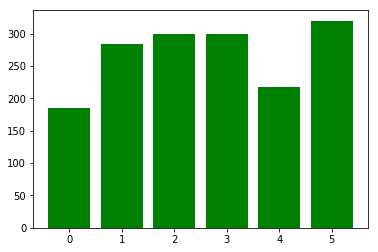

In [36]:
# bar plot of validation set class distribution

predicted_samples_per_class = {}

for cls in range(num_classes):
    predicted_samples_per_class[cls] = np.sum(y_val_converted == cls)

plt.bar(predicted_samples_per_class.keys(), predicted_samples_per_class.values(), color='g')

<BarContainer object of 6 artists>

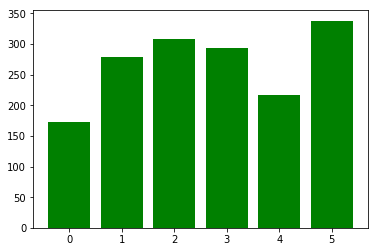

In [37]:
# bar plot of predictions per class

predicted_samples_per_class = {}

for cls in range(num_classes):
    predicted_samples_per_class[cls] = np.sum(hard_predictions == cls)

plt.bar(predicted_samples_per_class.keys(), predicted_samples_per_class.values(), color='g')

In [41]:
# Compile & Train the network on whole learning set

early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=50, restore_best_weights=True)
callbacks = [lrate]

model.compile(loss=loss_func, 
              optimizer=optimizer,
              metrics=metrics)

model.fit(learn_data, learn_labels,
          epochs=100,
          batch_size=batch_size,
          callbacks=callbacks)

Epoch 1/100
6425/6425 [==============================] - 3s 418us/step - loss: 0.3396 - acc: 0.8943
Epoch 2/100
6425/6425 [==============================] - 1s 97us/step - loss: 0.2268 - acc: 0.9296
Epoch 3/100
6425/6425 [==============================] - 1s 101us/step - loss: 0.1533 - acc: 0.9518
Epoch 4/100
6425/6425 [==============================] - 1s 102us/step - loss: 0.1437 - acc: 0.9528
Epoch 5/100
6425/6425 [==============================] - 1s 103us/step - loss: 0.1136 - acc: 0.9639
Epoch 6/100
6425/6425 [==============================] - 1s 112us/step - loss: 0.0948 - acc: 0.9718
Epoch 7/100
6425/6425 [==============================] - 1s 106us/step - loss: 0.0973 - acc: 0.9693
Epoch 8/100
6425/6425 [==============================] - 1s 102us/step - loss: 0.0928 - acc: 0.9721
Epoch 9/100
6425/6425 [==============================] - 1s 104us/step - loss: 0.1099 - acc: 0.9656
Epoch 10/100
6425/6425 [==============================] - 1s 112us/step - loss: 0.0988 - acc: 0.9684


In [42]:
prob_predictions = model.predict(test_data, batch_size=None, verbose=0, steps=None)
hard_predictions = np.argmax(prob_predictions, axis=1)

In [43]:
np.savetxt("your_submission.txt", hard_predictions, fmt='%i')

In [ ]:
03714713